In [1]:
#Trigger-Setting ofdmfft|source_sop either edge
import numpy as np  
import matplotlib.pyplot as plt
from signaldump import signaltapCsvDumper
import seaborn
plt.rcParams['figure.figsize']=[10,10]
import csv
import CommonScript as cs
import matplotlib.animation as animation
from bitstring import BitArray

0x50b0d838f8c8205858f828d0f8b8c8e0


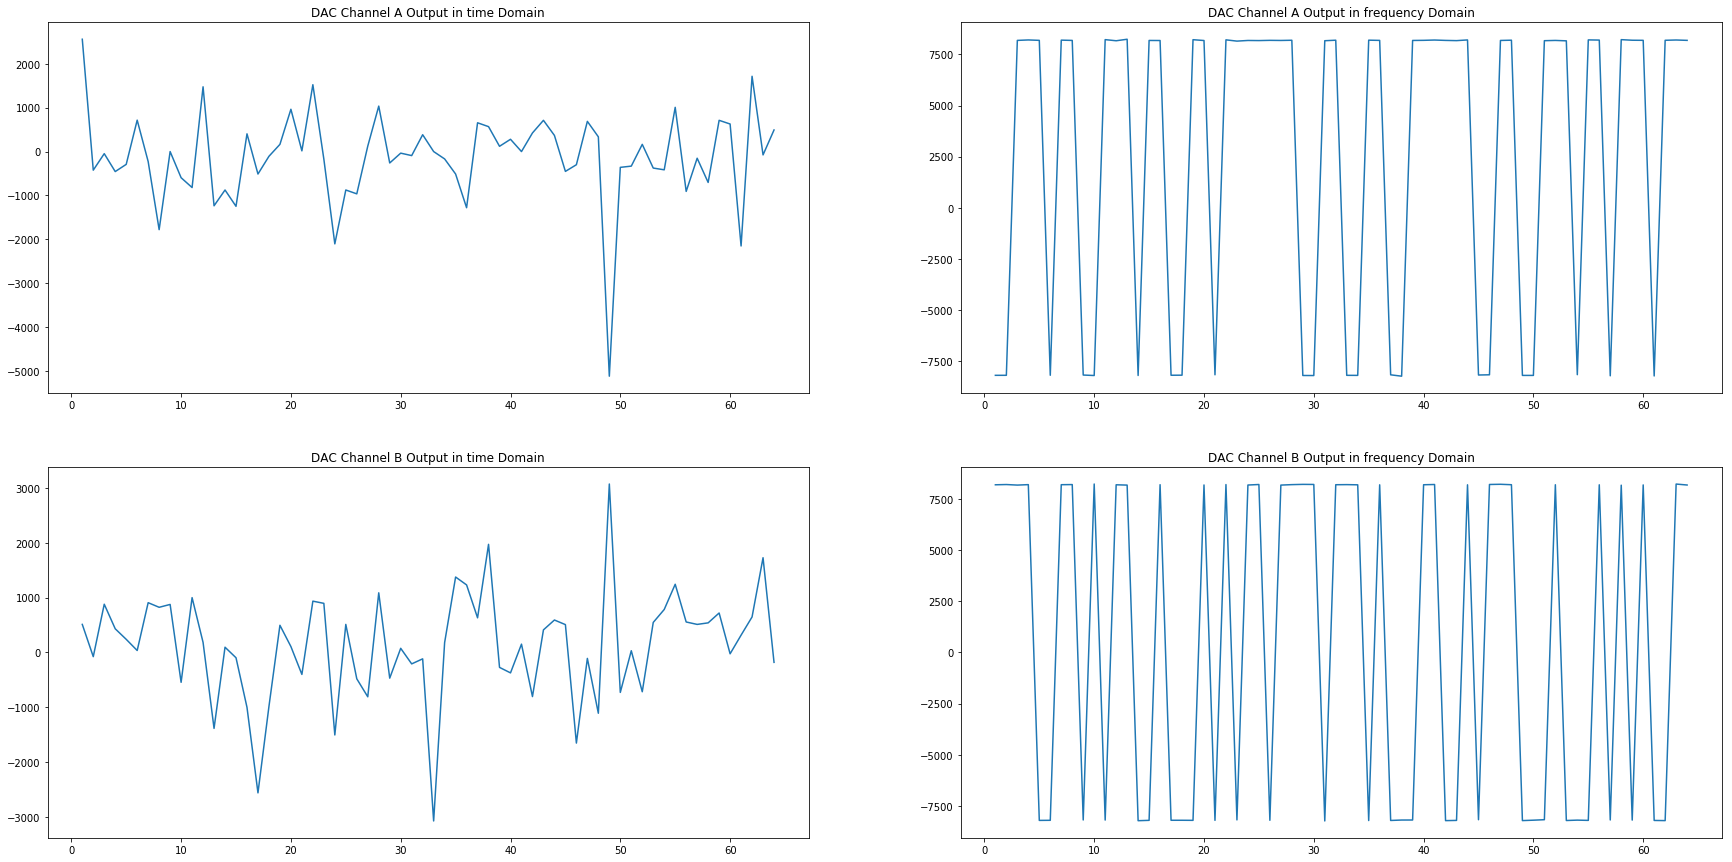

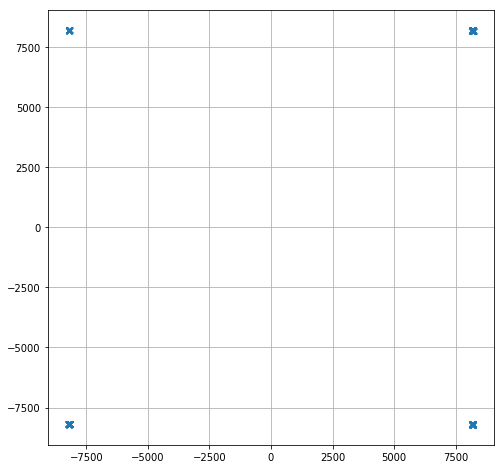

In [2]:
dumper=signaltapCsvDumper('../stp1.csv')
dumper.dumpSession(signalPattern=["DA\[(\d+)\]","DB\[(\d+)\]"],condition="active-high",validPattern=["ofdmdaccontrol|asi_in0_valid"],outputName="TransiverDAOutput",unsigned=True)
with open('./TransiverDAOutput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    real = np.array(csvBuffer[0],dtype=int)[::20]-8192
    imag = np.array(csvBuffer[1],dtype=int)[::20]-8192
    outSignal = real + imag*1j
    frequencyDomain=np.fft.fft(outSignal)
    plt.plot(lengthVector,real,'-')
    plt.title('DAC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('DAC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('DAC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-')

    plt.title('DAC Channel B Output in frequency Domain')

fftResult  = frequencyDomain
demodReal=np.real(fftResult)
demodImag=np.imag(fftResult)

plt.figure(figsize=(8,8))
plt.grid(True,axis='both',which='major')
plt.scatter(demodReal,demodImag,marker='x')

demodOut = cs.ConstellationDeMapping(demodReal,demodImag)

print(hex(int(demodOut,2)))
sendData = int(demodOut,2)


0x50b0d838f8c8205858f828d0f8b8c8e0
0.0


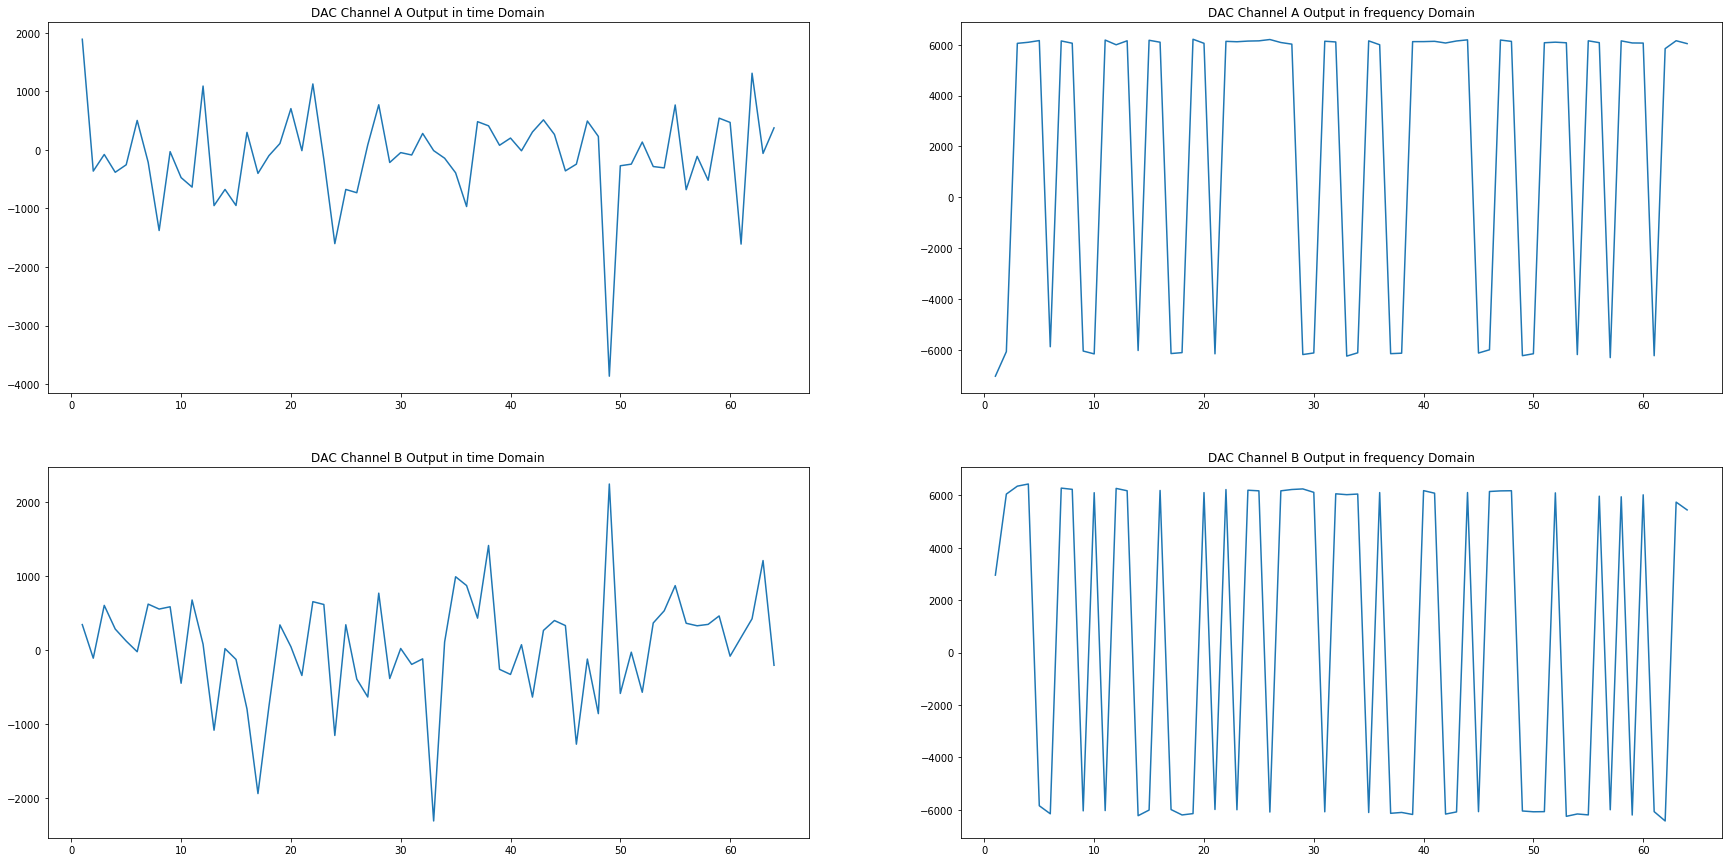

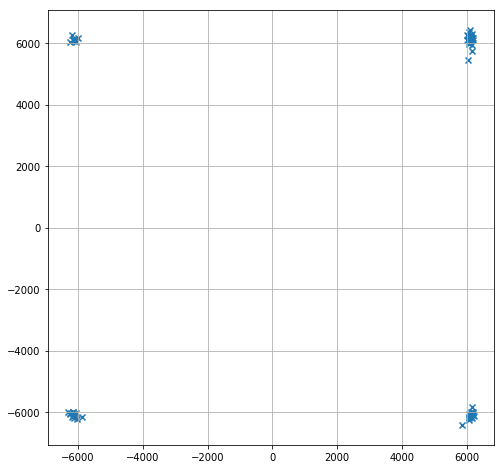

In [3]:
def symbolSync(series):
    accu_flag=0
    ma1=0
    ma2=0
    ma1_accu=0
    ma2_accu=0
    v2=0
    v1=0
    th=100
    for v,i in enumerate(real):
        ma1_accu=ma1_accu+i
        ma2_accu=ma2_accu+i
        if(v2==3):
            ma2=ma2_accu//4
#             print(ma2,ma2-ma1)
            if(accu_flag):
                if(abs(ma1-ma2)>th):
                    return v+8
            v2=0
            ma2_accu=0
        else:
            v2=v2+1
        if(v1==31):
            accu_flag=1
            ma1=ma1_accu//32
            v1=0
            ma1_accu=0
        else:
            v1=v1+1
   
dumper.dumpSession(signalPattern=["ADA_D\[(\d+)\]","ADB_D\[(\d+)\]"],condition="range",inf=0,sup=4000,outputName="ReceiverADInput")

with open('./ReceiverADInput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    real = np.negative(np.array(csvBuffer[0],dtype=int))
    imag = np.negative(np.array(csvBuffer[1],dtype=int))
    reagIndex=symbolSync(real)
    imagIndex=symbolSync(imag)
    real = real[reagIndex:reagIndex+1279:20]
    imag = imag[imagIndex:imagIndex+1279:20]
    outSignal = real + imag*1j
    frequencyDomain=np.fft.fft(outSignal)
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    plt.plot(lengthVector,real,'-')
    plt.title('DAC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('DAC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('DAC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-')

    plt.title('DAC Channel B Output in frequency Domain')

    fftResult  = frequencyDomain
    demodReal=np.real(fftResult)
    demodImag=np.imag(fftResult)

    plt.figure(figsize=(8,8))
    plt.grid(True,axis='both',which='major')
    plt.scatter(demodReal[1:],demodImag[1:],marker='x')

    demodOut = cs.ConstellationDeMapping(demodReal,demodImag)
    #Calculate BER
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)



            
        
        
    



128
[  -76  -291   -86  -375  -261   478  -195 -1344   -64  -446  -630  1034
  -886  -692  -942   259  -381  -106   106   684    17  1088  -124 -1561
  -702  -722    62   744  -181   -51   -80   268   -13  -142  -391  -952
   440   412    82   199    -2   313   509   271  -344  -244   473   238
 -3737  -379  -248   129  -267  -313   731  -630  -128  -495   521   474
 -1546  1214   -14   364]
[  -79   -86   583   283   134   -23   598   557   589  -428   638    94
 -1058   -21  -128  -769 -1916  -801   300    61  -321   619   614 -1106
   293  -382  -632   718  -354     7  -189  -126 -2245    38   965   882
   440  1377  -205  -330    58  -617   235   390   337 -1230  -159  -838
  2140  -501   -51  -560   329   524   858   382   325   345   467   -67
   160   405  1186  -170]
0x50b0d838f8c8205858f828d0f8b8c8e0
0.0


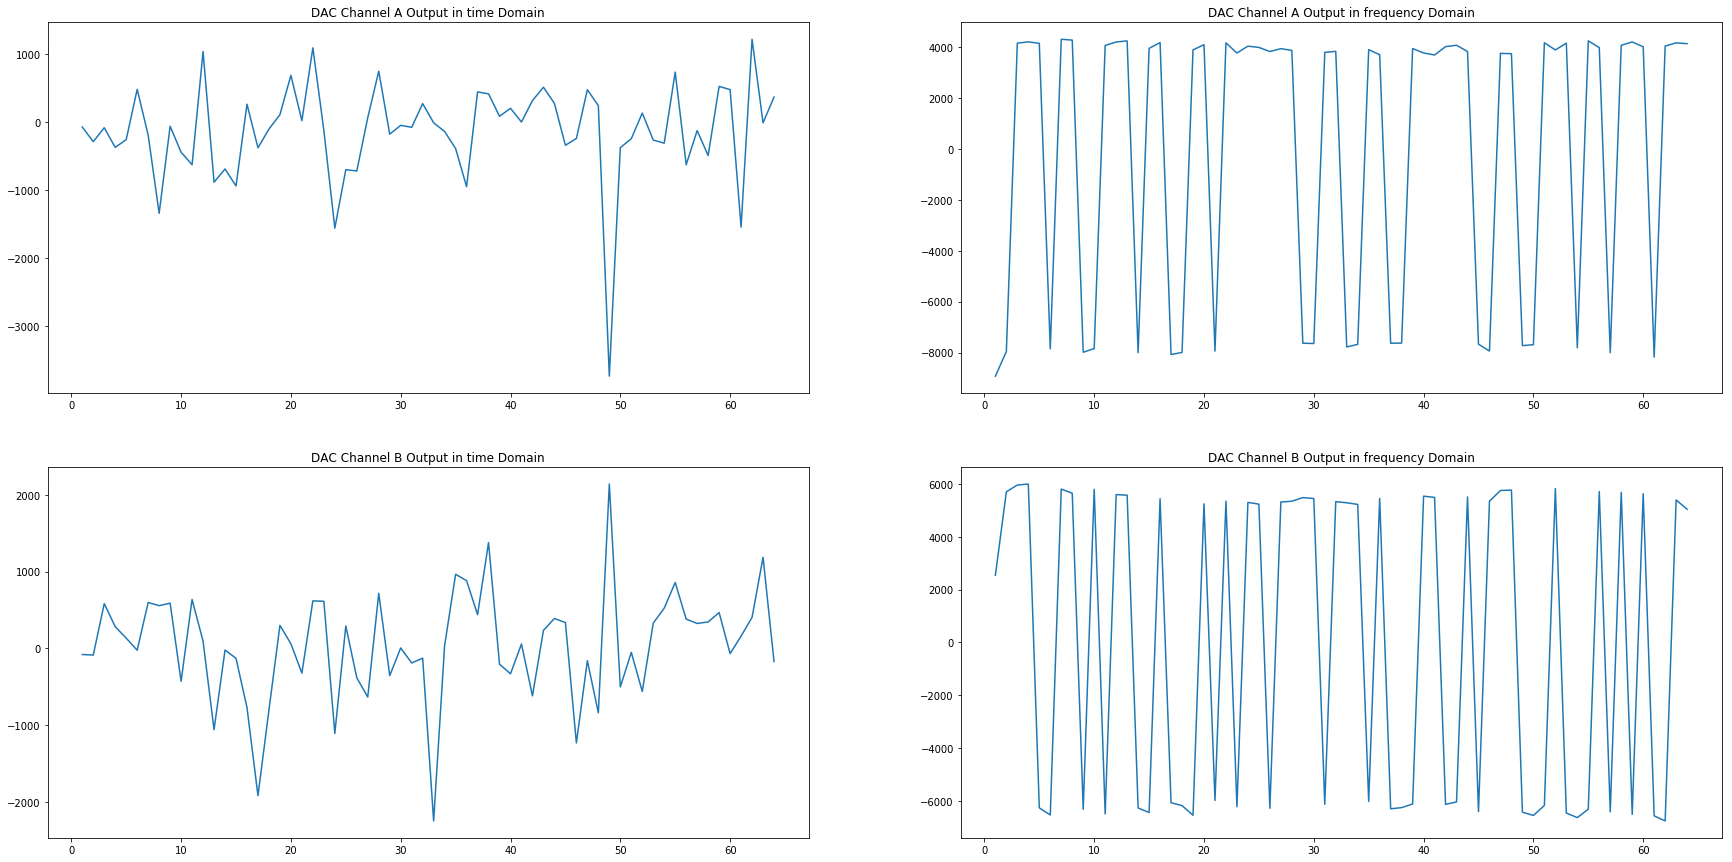

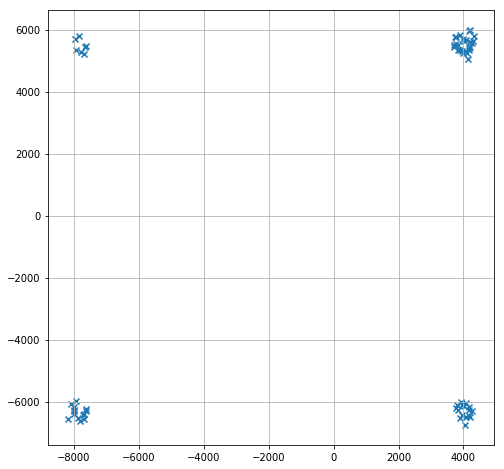

In [4]:
dumper=signaltapCsvDumper('../stp1.csv')
dumper.dumpSession(signalPattern=["ofdmsymbolsync\|aso_out0_data\[(\d+)\]"],condition="active-high",validPattern=["ofdmsymbolsync|aso_out0_valid"],outputName="ReceiverSyncOutput")
with open('./ReceiverSyncOutput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    data = np.array(csvBuffer[0],dtype=int)
    data = [np.binary_repr(i,width=32) for i in data]
    real = np.array([BitArray(bin=i[0:16]).int for i in data])
    imag = np.array([BitArray(bin=i[16:]).int for i in data])
    print(real.size)

    real = real[0::2]
    imag = imag[0::2]
    print(real)
    print(imag)
    outSignal = real + imag*1j
    frequencyDomain=np.fft.fft(outSignal)
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    plt.plot(lengthVector,real,'-')
    plt.title('DAC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('DAC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('DAC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-')

    plt.title('DAC Channel B Output in frequency Domain')

    fftResult  = frequencyDomain
    demodReal=np.real(fftResult)
    demodImag=np.imag(fftResult)

    plt.figure(figsize=(8,8))
    plt.grid(True,axis='both',which='major')
    plt.scatter(demodReal[1:],demodImag[1:],marker='x')

    demodOut = cs.ConstellationDeMapping(demodReal,demodImag)
    #Calculate BER
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)


[  -76  -291   -86  -375  -261   478  -195 -1344   -64  -446  -630  1034
  -886  -692  -942   259  -381  -106   106   684    17  1088  -124 -1561
  -702  -722    62   744  -181   -51   -80   268   -13  -142  -391  -952
   440   412    82   199    -2   313   509   271  -344  -244   473   238
 -3737  -379  -248   129  -267  -313   731  -630  -128  -495   521   474
 -1546  1214   -14   364]
[  -79   -86   583   283   134   -23   598   557   589  -428   638    94
 -1058   -21  -128  -769 -1916  -801   300    61  -321   619   614 -1106
   293  -382  -632   718  -354     7  -189  -126 -2245    38   965   882
   440  1377  -205  -330    58  -617   235   390   337 -1230  -159  -838
  2140  -501   -51  -560   329   524   858   382   325   345   467   -67
   160   405  1186  -170]
0x50b0d838f8c8205858f828d0f8b8c8e0
0.0


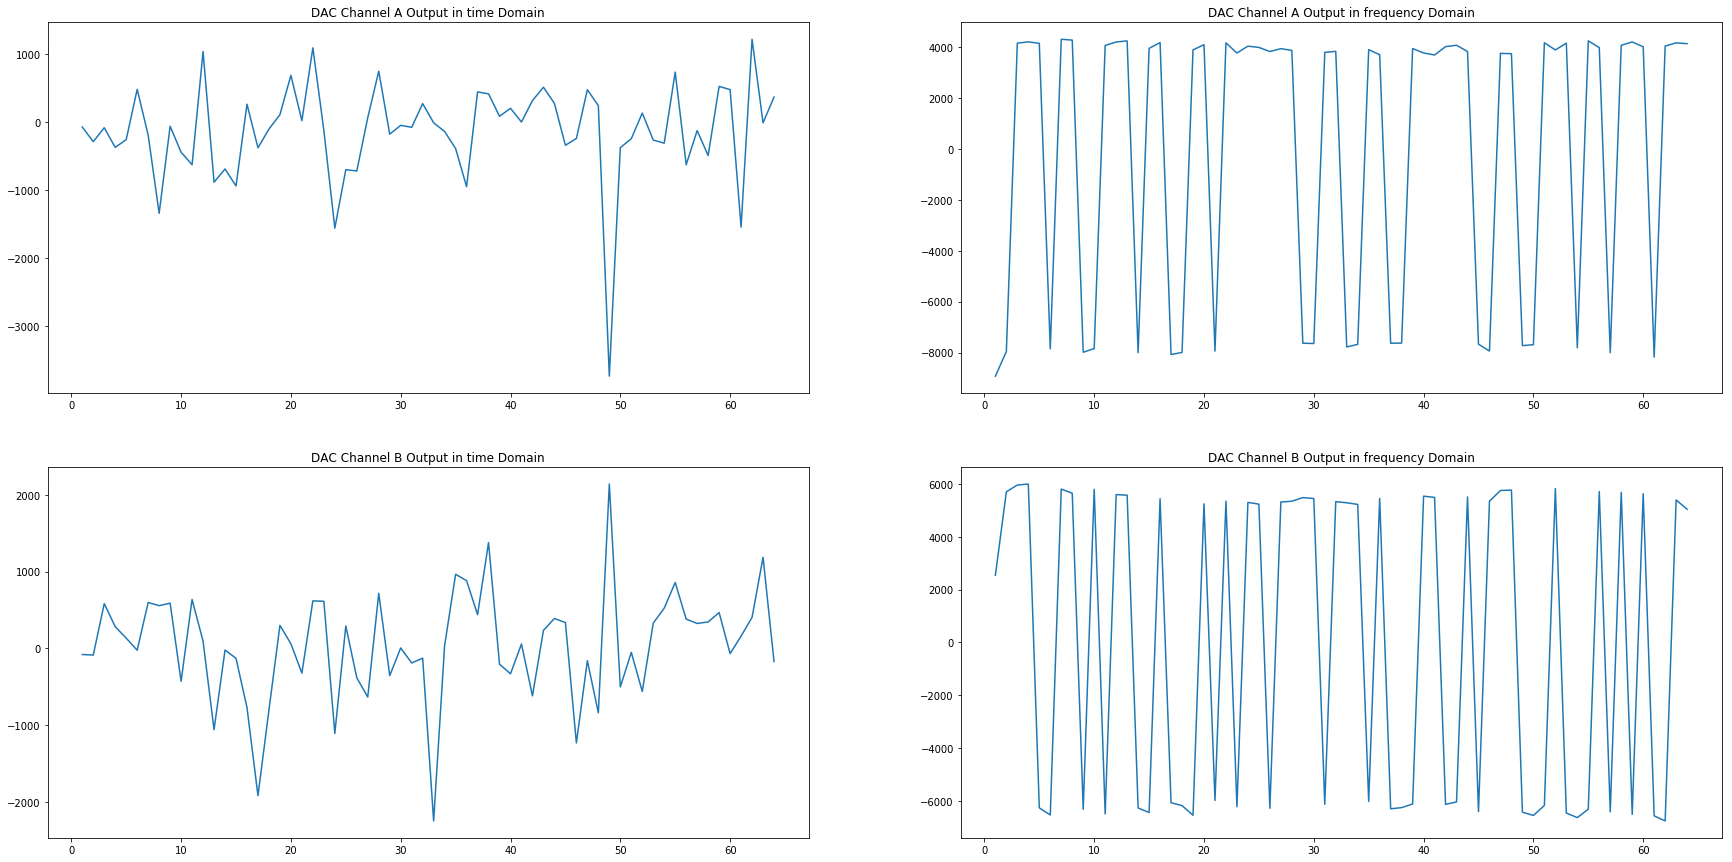

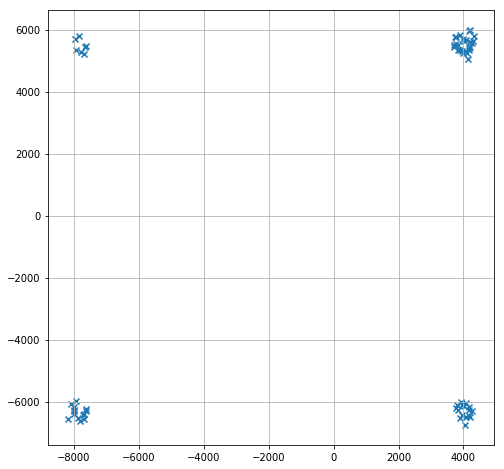

In [5]:
dumper=signaltapCsvDumper('../stp1.csv')
dumper.dumpSession(signalPattern=[".*ReceiverTopQsys_0_FFT:fft\|sink_real\[(\d+)\]",".*ReceiverTopQsys_0_FFT:fft\|sink_imag\[(\d+)\]"],condition="active-high",validPattern=["ReceiverTopQsys_0_FFT:fft|sink_valid"],outputName="RXFFTInput")
with open('./RXFFTInput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    data = np.array(csvBuffer,dtype=int)
    real=data[0][::2]
    imag=data[1][::2]

    print(real)
    print(imag)
    outSignal = real + imag*1j
    frequencyDomain=np.fft.fft(outSignal)
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    plt.plot(lengthVector,real,'-')
    plt.title('DAC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('DAC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('DAC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-')

    plt.title('DAC Channel B Output in frequency Domain')

    fftResult  = frequencyDomain
    demodReal=np.real(fftResult)
    demodImag=np.imag(fftResult)

    plt.figure(figsize=(8,8))
    plt.grid(True,axis='both',which='major')
    plt.scatter(demodReal[1:],demodImag[1:],marker='x')

    demodOut = cs.ConstellationDeMapping(demodReal,demodImag)
    #Calculate BER
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)


[-620 -517  220  225 -528  235  233  242  233 -527  224  243  224 -507
  221  237 -524 -502  236  233 -523 -502  230  227  211 -510  214  218
  206 -504  212  212 -506 -499  217  206  213 -509  214  208  227 -497
  215  213 -507 -498  241  207  239 -506  242  219  226  227  229  234
 -517  241  237  240 -527  239  256  271]
[-529 -448  328  329 -449  312  310  311  307 -445 -459  300 -457  316
 -447  296 -429  305  290  289 -426  305  282  290 -438 -430 -440  280
 -436  292 -430  286  288  286  292  291  303  284  300  300 -421 -448
  302  301 -449 -453 -435  308 -431 -457 -435  306  318  312  320  318
 -460 -447  303  301 -452 -467  281  272]
0x50b0d838f8c8205858f828d0f8b8c8e0
0.0


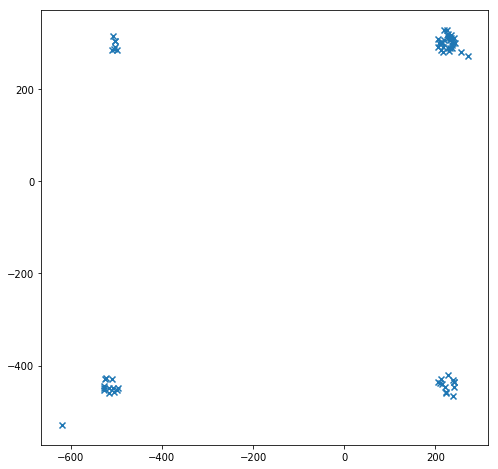

In [9]:
dumper=signaltapCsvDumper('../stp1.csv')
dumper.dumpSession(signalPattern=[".*ReceiverTopQsys_0_FFT:fft\|source_real\[(\d+)\]",".*ReceiverTopQsys_0_FFT:fft\|source_imag\[(\d+)\]"],condition="active-high",validPattern=["ReceiverTopQsys_0_FFT:fft|source_valid"],outputName="RXFFTOutput")
with open('./RXFFTOutput.csv') as fp:
    csvBuffer=list(csv.reader(fp))
    data = np.array(csvBuffer,dtype=int)
    real=data[0][::2]
    imag=data[1][::2]
    plt.figure(figsize=(8,8))
    plt.scatter(real,imag,marker='x')
    print(real)
    print(imag)


    demodOut = cs.ConstellationDeMapping(demodReal,demodImag)
    #Calculate BER
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)
